# Company Bankruptcy Prediction 

Author: Mert Ertugrul

Status: In-progress

This notebook was prepared to work on the task "Company Bankruptcy Prediction" found at the following link: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction

Dataset description provided: "The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange."

-Dataset includes 95 features, almost all are numerical. High dimensinality will be an important factor in model choice, feature selection and extraction.

## Procedure Followed

As we will see in the following analysis, there will be a number of decisions to be made on how to approach our data:

**1 - Feautures comprising our data are on different scales, should we transform the data to account for it?** 
  - For features with skewed distributions, we will first apply log transform.
  - We will standardize the dataset.
  - Looking at the plots of the most important feature pairs, we will elminate data points that do not obey the main trend observed
    
**2- Our data is drastically unbalanced with the positive label representing only 3% of data points. Then, should we include steps to balance our training dataset? If so, which methods should we use?** 

  - We will carry out the entire process first without and later with artificially balaced data. Then, we will compare the results.
    
**3- Our data is very high dimensional. Should we choose subsets of the available features?**

  - We will use ANOVA F measure to assign scores to each feature and select k features with the highest scores. We will train our models with a range of different k values and keep the best performing feature set.
  - We will also use PCA to extract features and repeat the process with k principle components, varying k.

In [113]:
#Imports
import sys, warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE


from sklearn import decomposition, tree, preprocessing
from sklearn.preprocessing import scale, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
from xgboost import XGBClassifier

In [114]:
#Loading the data
df_unclean = pd.read_csv("/kaggle/input/company-bankruptcy-prediction/data.csv")

## General structure of the dataset

### Displaying the first few rows

In [115]:
df_unclean.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### Looking for missing values

In [116]:
# get null values
null_values = df_unclean.isnull().sum().sum()
print('Null:', null_values)
# get nan values
nan_values = np.isnan(df_unclean.values).sum()
print('Nan:', nan_values)

Null: 0
Nan: 0


No missing values are present in the dataset.

### Displaying the feature names and types

In [117]:
df_unclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

We see that all features other than  "Net Income Flag" and "Liability-Assets Flag" are numerical. 

In [118]:
df_unclean.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


#### Train-Test Split

In [119]:
Y = df_unclean['Bankrupt?']
X = df_unclean.drop('Bankrupt?', axis=1)

#X_cv , Y_cv will be used for model and parameter selection with cross validation
#X_cv_unclean,X_test,Y_cv_unclean,Y_test  = train_test_split(X_scaled, Y, test_size=0.1, stratify = Y, random_state = 42)
X_train_unscaled,X_test_unscaled,Y_train,Y_test  = train_test_split(X, Y, test_size=0.1, stratify = Y, random_state = 42)

### Log Transform and Standardization

In [120]:
from scipy.stats import skew

In [121]:
#drop the features with zero standard deviation (only one value accross all features)
X_train_unscaled.drop(X_train_unscaled.std()[X_train_unscaled.std() == 0].index.values, axis=1)
X_test_unscaled.drop(X_train_unscaled.std()[X_train_unscaled.std() == 0].index.values, axis=1)
                   
#finding the skewed features to log transform them 
skewness = X_train_unscaled.apply(lambda x : skew(x))
skewness = skewness[abs(skewness)>0.5]
skewed_features = skewness.index

print("Number of Skewed Features: \n",len(skewed_features))

#Log transform the skewed features
X_train_unscaled[skewed_features] = np.log1p(X_train_unscaled[skewed_features])
X_test_unscaled[skewed_features] = np.log1p(X_test_unscaled[skewed_features])

#standardizing the data 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_unscaled.loc[:, X_train_unscaled.columns])

X_train = X_train_unscaled.copy()
X_test = X_test_unscaled.copy()

X_train.loc[:, X_train_unscaled.columns] = scaler.transform(X_train_unscaled.loc[:, X_train_unscaled.columns])
X_test.loc[:, X_test_unscaled.columns] = scaler.transform(X_test_unscaled.loc[:, X_test_unscaled.columns])

#new datafram for display purposes
df_train = pd.concat([X_train,Y_train],axis=1)

Number of Skewed Features: 
 88


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]



### Displaying the distributions of the features

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


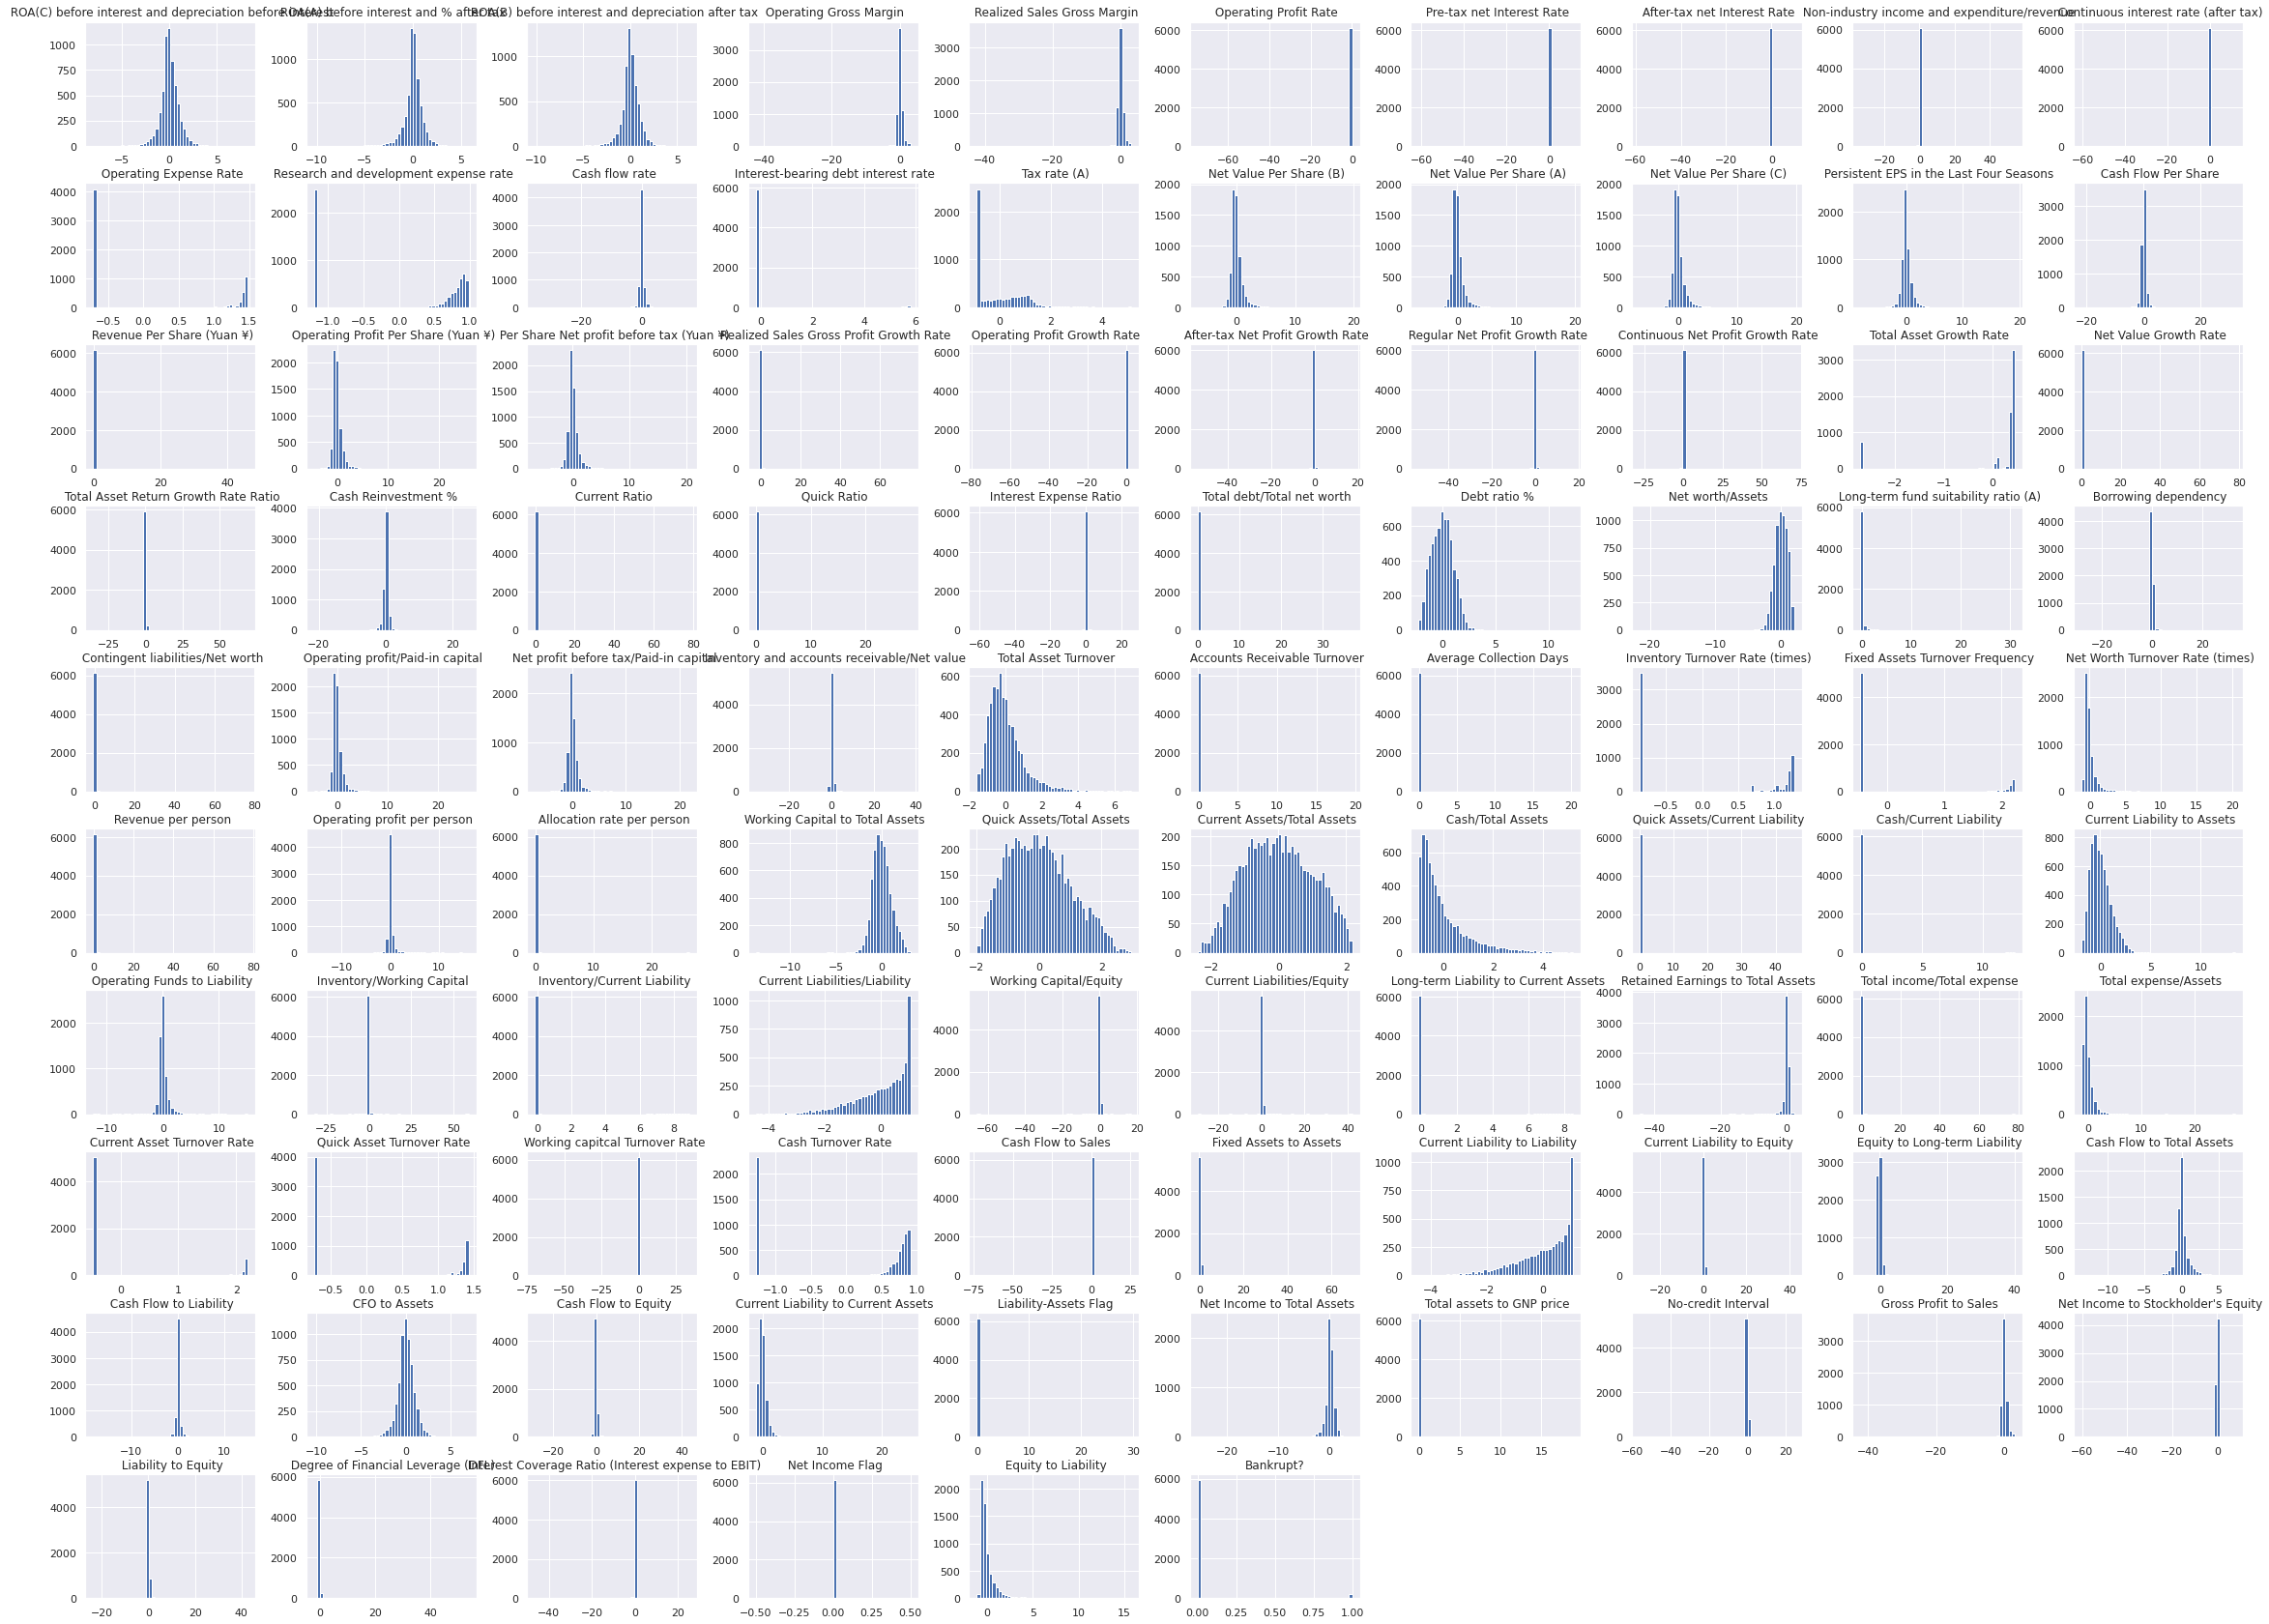

In [122]:
df_train.hist(figsize = (40,30),bins = 50)
plt.show()

It is apparent that our features come in groups of different distributions, some resembling exponential while some more similar to normal or skewed normal distributions. We also know that most features are numerical and are on different scales. Log transformation could not eliminate the skewness of most distributions.


Now we inspect the correlation matrix of the features to observe the relationships between them.

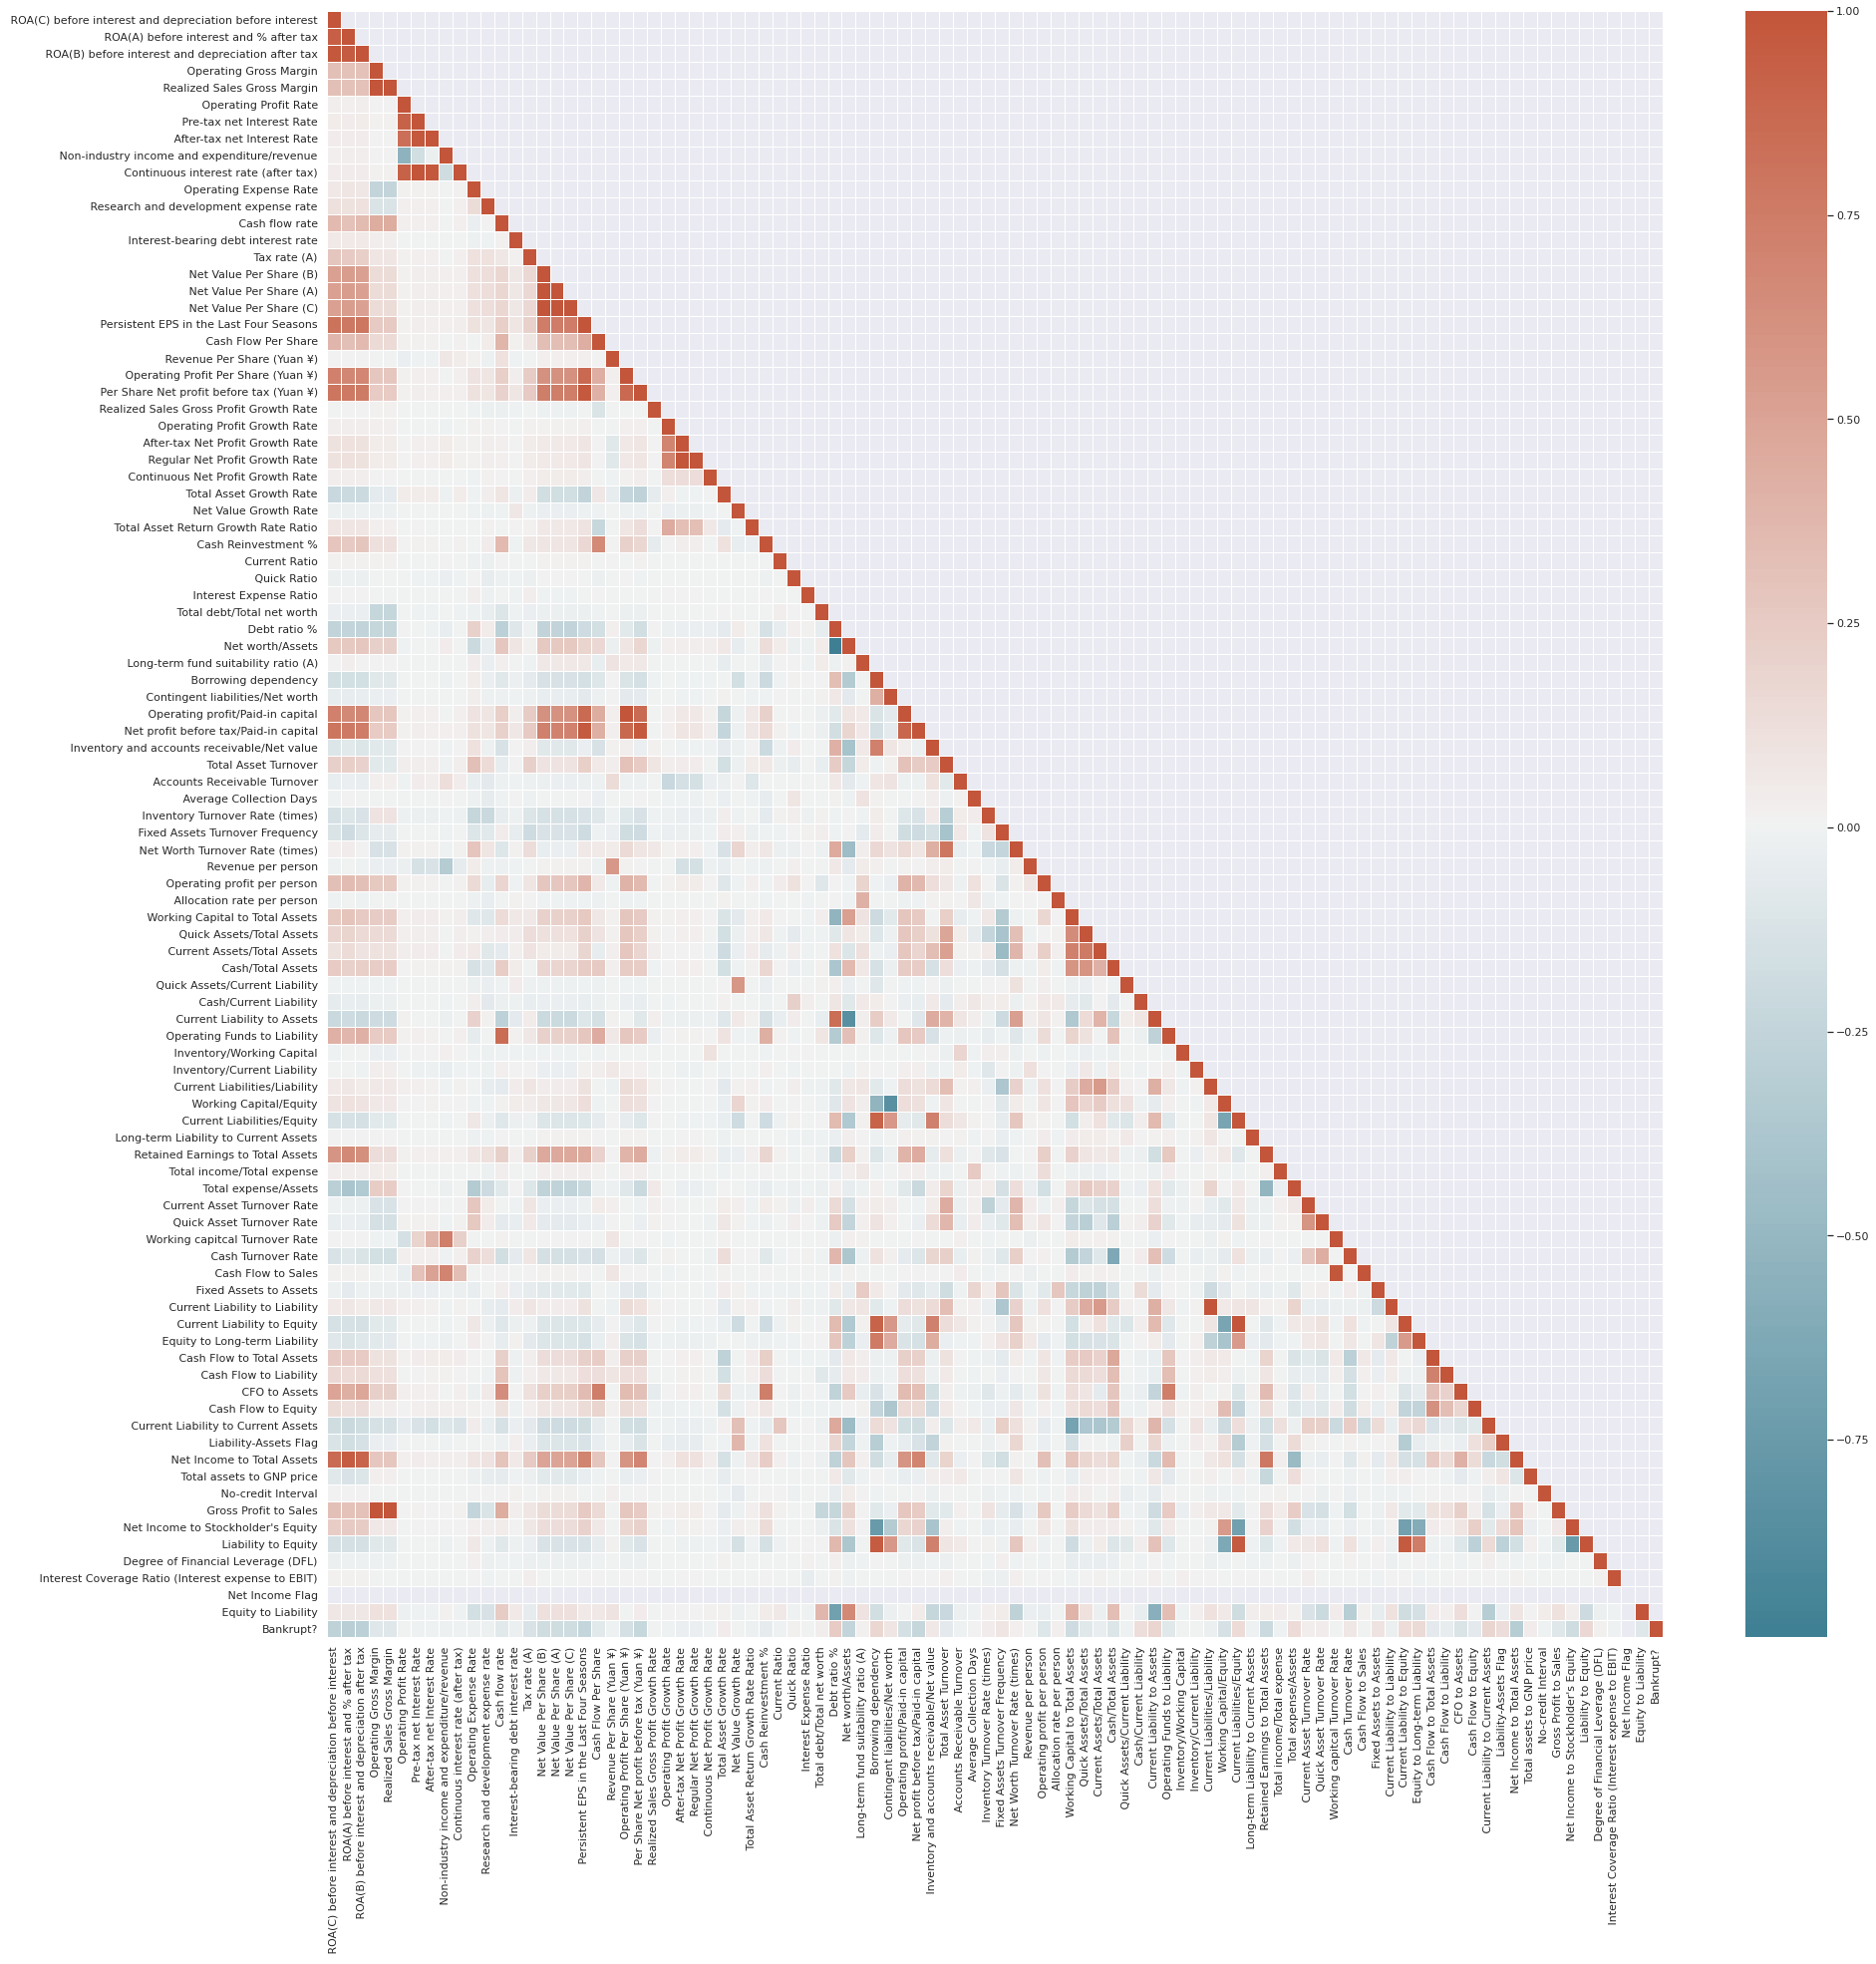

In [123]:
corr_mat = df_train.corr()
#lower trainglular part of the correlation matrix
lt_mat = corr_mat.where(np.tril(np.ones(corr_mat.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize=(30,30))   

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(lt_mat, linewidths=0.5,cmap=cmap, ax=ax)
plt.show()

One thing to point out is that there are groups of features that appear highly correlated with each other as well as the label. When we use a feauture selection method we will get a number of redundant features in the process as well.
Before appying feature selection methods based on the statistical proeperties of the individual  features, it may help to drop features that are duplicates or inverted versions of each other in terms of the information they provide. 

In [124]:
corr_cols = corr_mat.abs().nlargest(21,'Bankrupt?')['Bankrupt?'].index
print("Features that are the most correlated (positively or negatively) to the label:\n",corr_cols)

Features that are the most correlated (positively or negatively) to the label:
 Index(['Bankrupt?', ' Net Income to Total Assets',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' ROA(C) before interest and depreciation before interest',
       ' Net worth/Assets', ' Debt ratio %',
       ' Persistent EPS in the Last Four Seasons',
       ' Net profit before tax/Paid-in capital',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Retained Earnings to Total Assets', ' Current Liability to Assets',
       ' Working Capital to Total Assets',
       ' Current Liability to Current Assets', ' Net Value Per Share (A)',
       ' Net Value Per Share (B)', ' Net Income to Stockholder's Equity',
       ' Net Value Per Share (C)', ' Borrowing dependency',
       ' Liability to Equity', ' Equity to Long-term Liability'],
      dtype='object')


We must note that some of these collumns are likely to have high colinearity and be redundant, which we will try to analyzse later. Now we observe the relationships between the features.

This section was inspired by: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

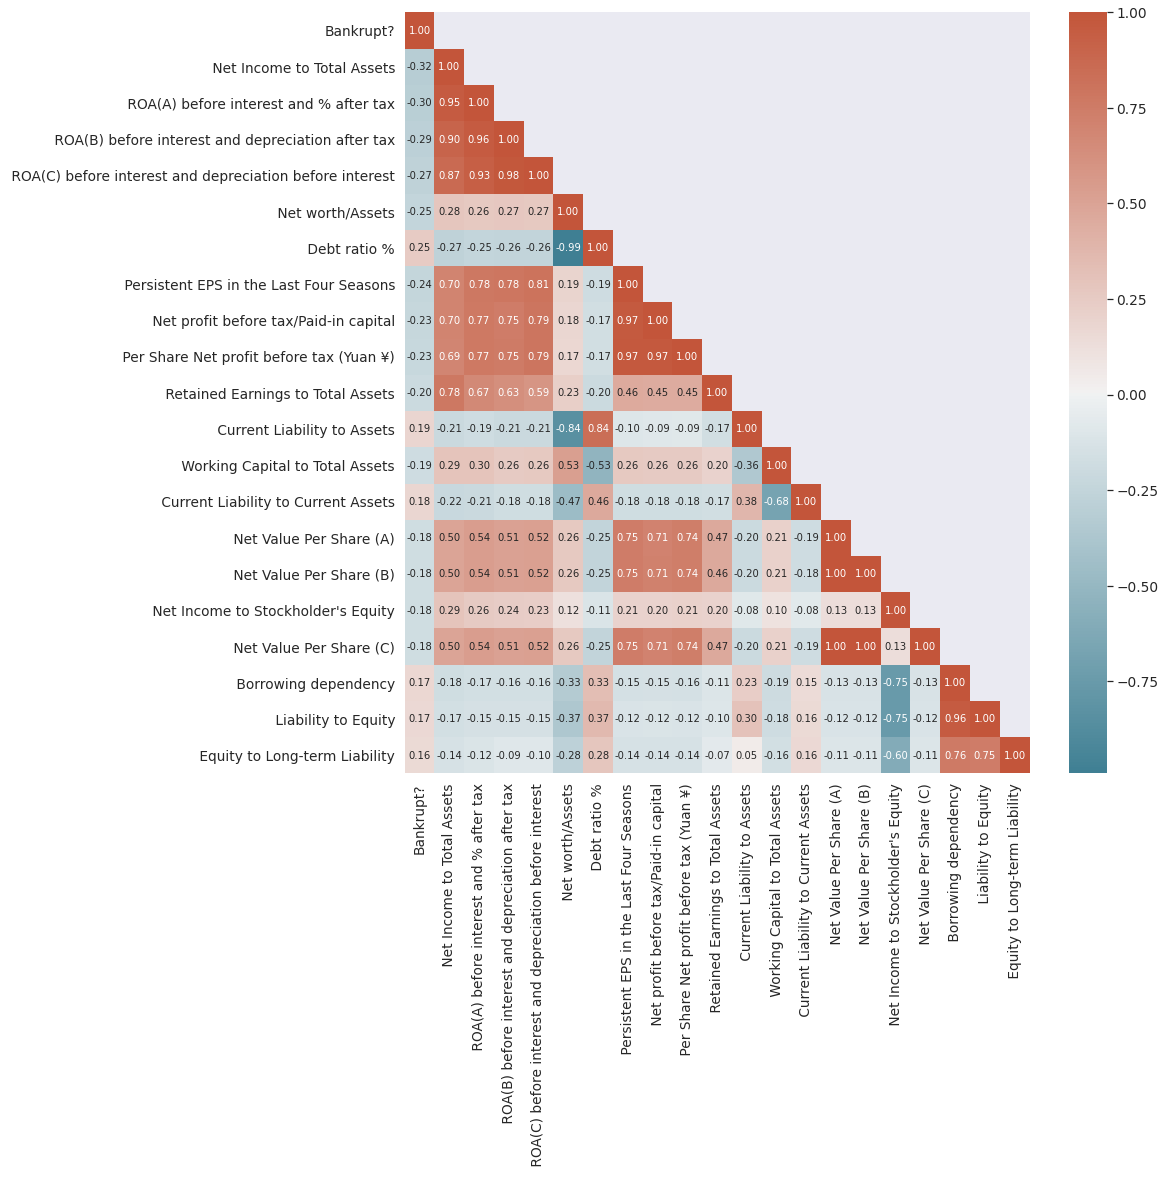

In [125]:
cm = df_train[corr_cols].corr()
#lower trainglular part of the correlation matrix
lt_cm = cm.where(np.tril(np.ones(cm.shape)).astype(np.bool))

sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(14,14))   
cmap = sns.diverging_palette(220, 20, as_cmap=True)

heatmap = sns.heatmap(lt_cm, cbar=True, annot=True, cmap=cmap, fmt='.2f',annot_kws={'size': 10})

It appears that none of the existing features is very highly correlated with the label but high colinearity between the features is present to the point where some features behave identically. This is not suprising for many of the financial indicators, such as the pair of 

**Debt ratio %**  and  **Net Worth/Assets**                   
since:                                               
    ***Net Worth/Assets = (Assets – Liabilities)/Assets***                                       
    and                                  
    ***Debt ratio = Liablities / Assets***                      
so we should have:                             
    **Net Worth/Assets = 1 - Debt ratio**
    
These types of relationships are present for most of the indicators, with variations such as the difference between "current liabilities" versus "total liablities" leading to differences between the information provided by the indicators, which we observe with the "Current Liabilites to Assets" feature. This feature has a correlation cofficient of 0.84 with "Debt Ratio %" 

A similar case can be made for "Borrowing Dependency" and "Lability to Equity" which have a correlation coefficient of 0.96.

The high correlation coefficients here do not necessarily mean that the features are redundant as the differences between them may provide valuable insights about bankruptcy likelihood. 

On the other hand, the corrlation coefficinet of 1 between "Net Value Per Share(A)", "Net Value Per Share(B)" and "Net Value Per Share(C)" indicates an obvious redundance.


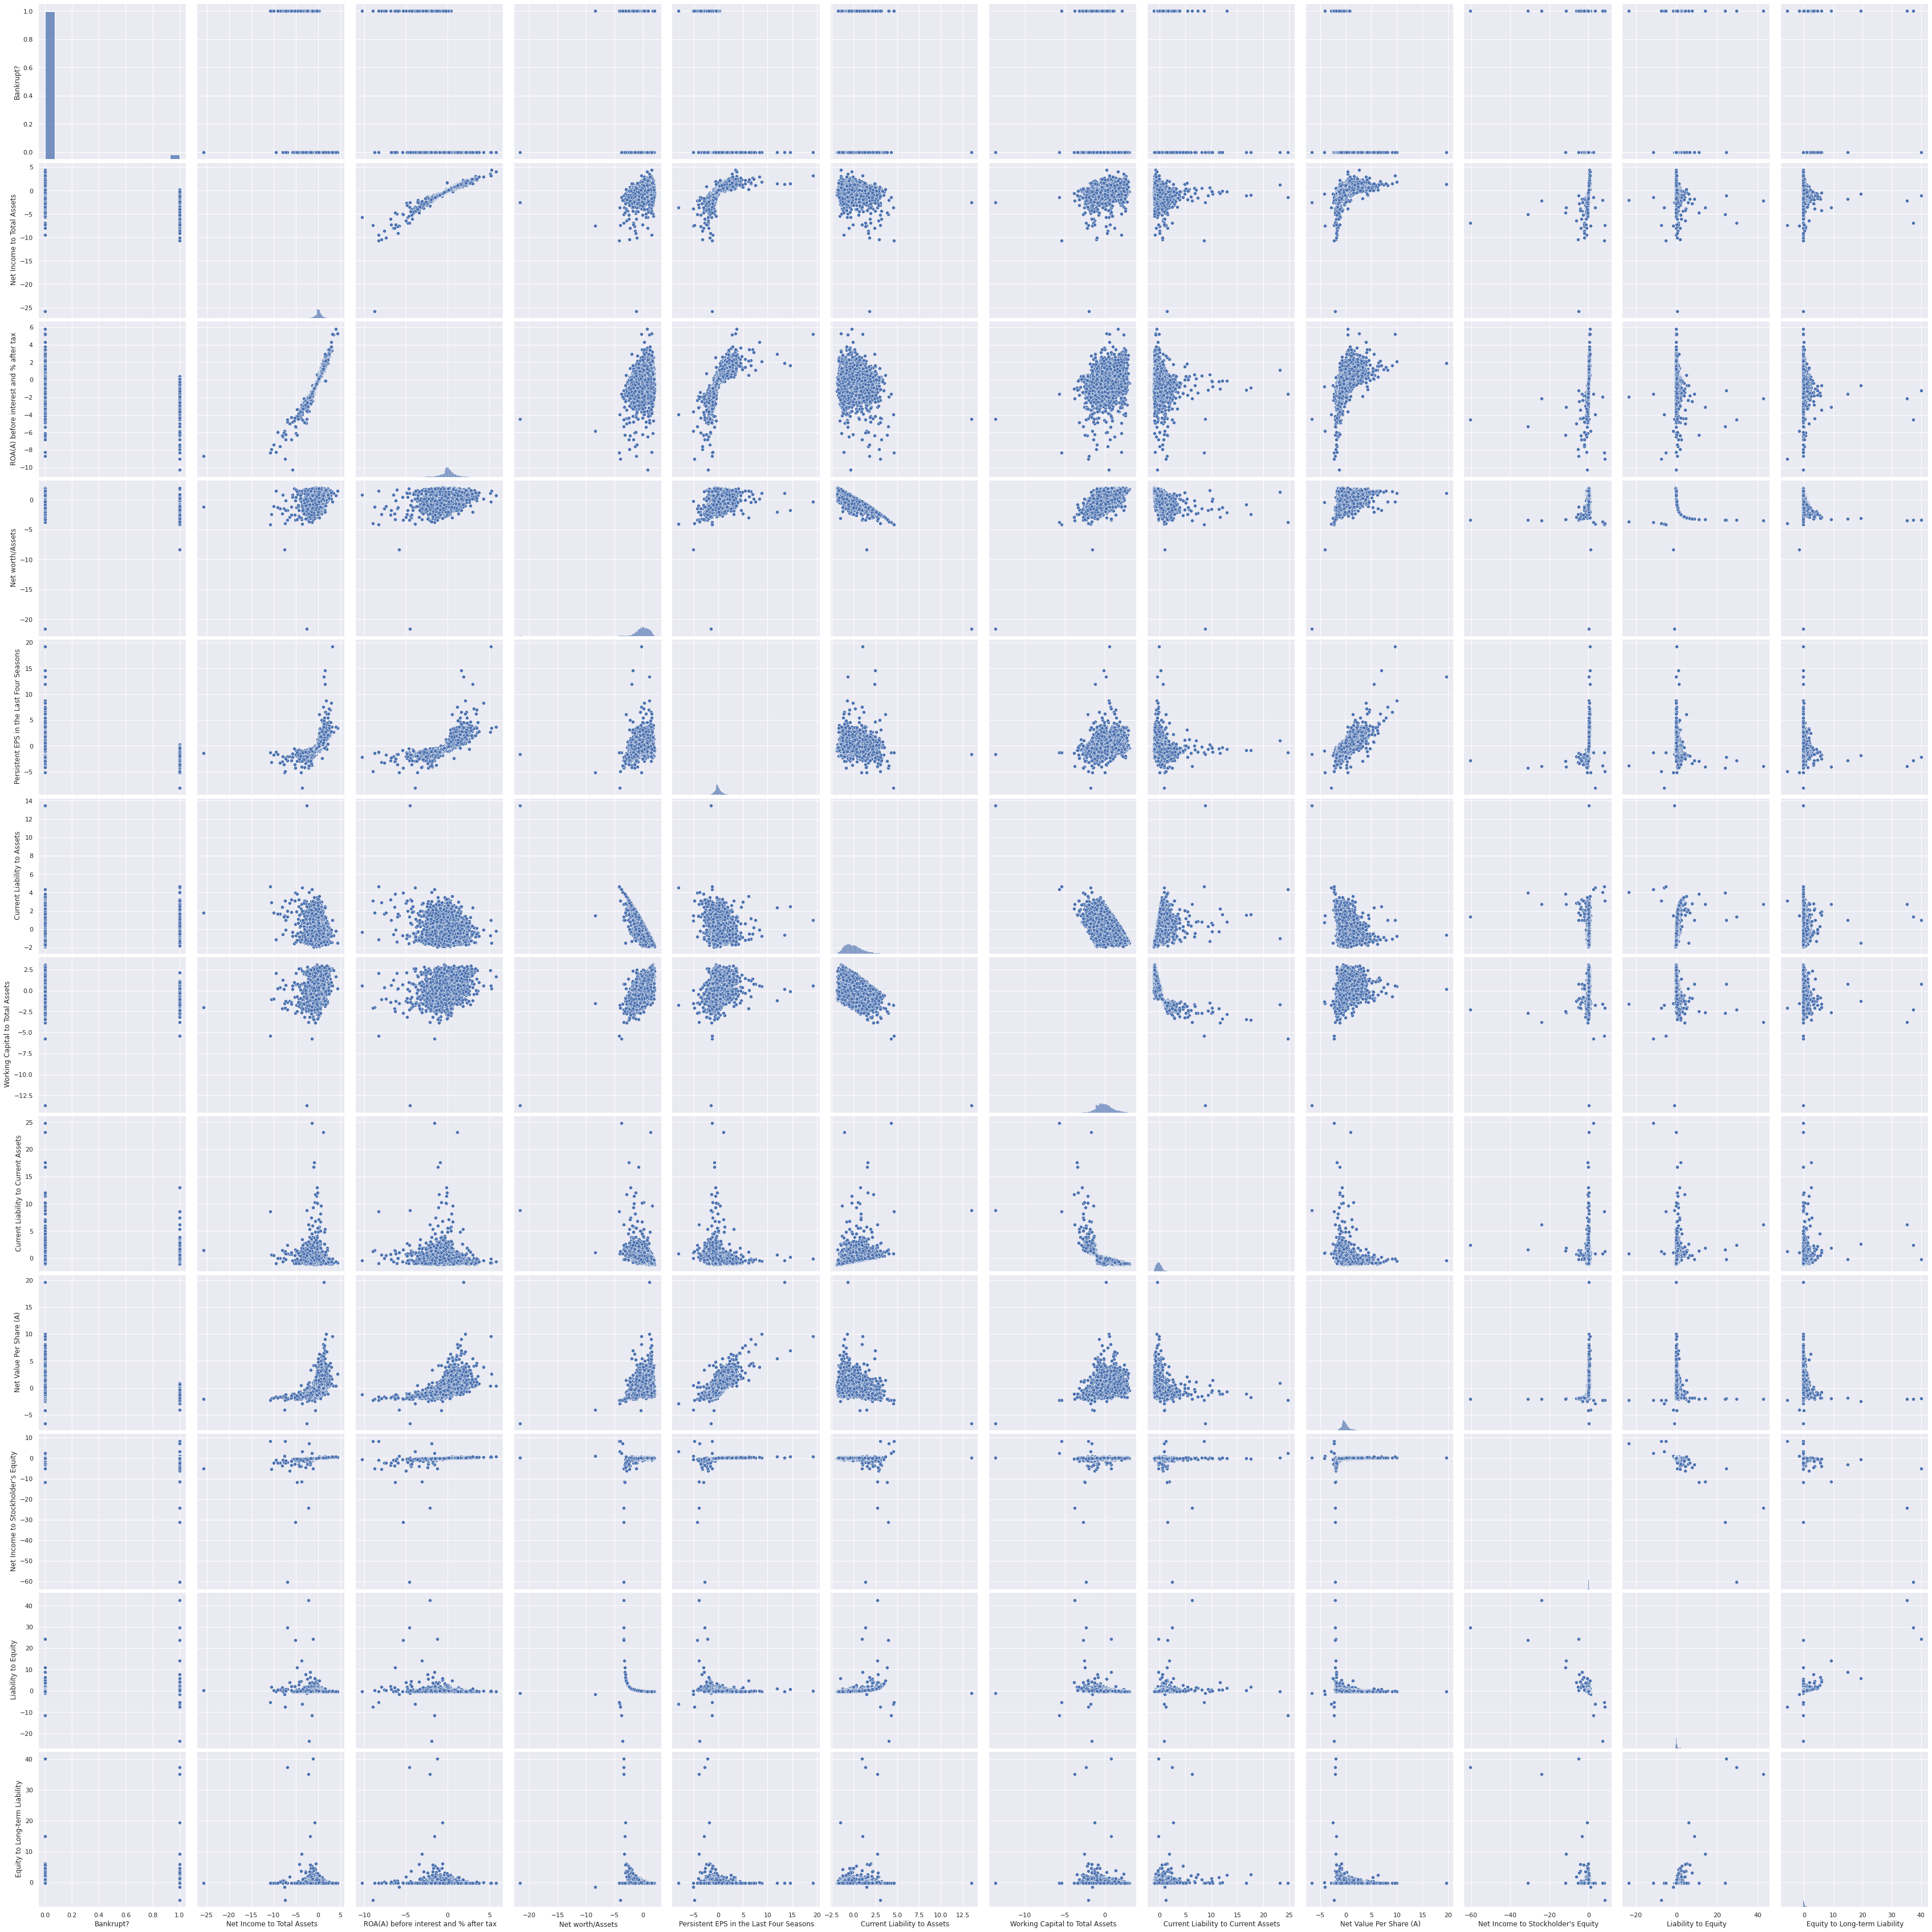

In [126]:
#For display purposes, we get rid of the columns that showed the greatest similarity below.
new_cols = ['Bankrupt?', ' Net Income to Total Assets',
       ' ROA(A) before interest and % after tax',
       ' Net worth/Assets', 
       ' Persistent EPS in the Last Four Seasons',
       ' Current Liability to Assets',
       ' Working Capital to Total Assets',
       ' Current Liability to Current Assets', ' Net Value Per Share (A)',
       " Net Income to Stockholder's Equity",
       ' Liability to Equity', ' Equity to Long-term Liability']
sns.set()
sns.pairplot(df_train[new_cols],height=4)
plt.show();

Looking at the above pair plots, we will determine outlier thresholds for certain features and drop outliers.

In [127]:
df_train = df_train[df_train[' Equity to Long-term Liability'] < 10]
df_train = df_train[df_train[' Equity to Long-term Liability'] > -1]
df_train = df_train[df_train[' Net worth/Assets'] > -15]
df_train = df_train[df_train[' Working Capital to Total Assets'] > -7.5]
df_train = df_train[df_train[" Net Income to Stockholder's Equity"] > -10]
df_train = df_train[df_train[" Current Liability to Assets"] < 6]
df_train = df_train[df_train[' Liability to Equity'] < 20]
df_train = df_train[df_train[' Liability to Equity'] > -5]
df_train = df_train[df_train[' Working Capital to Total Assets'] > -5]

print("Remaining dataset size: ",df_train.shape[0])


Remaining dataset size:  6122


Now, looking at the pair plots, we will add new features to the dataset.

Inspired by the ploynomial feature engineering in: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [128]:
#adds 5 new features based on the pair plots
def add_poly_features(old_df):

    
    new_df = old_df.copy()
    
    new_df[' Working Capital to Total Assets-s2'] = ( old_df[' Working Capital to Total Assets'] - old_df[' Working Capital to Total Assets'].min() ) ** 2
    new_df[' Working Capital to Total Assets-s2'] = (new_df[' Working Capital to Total Assets-s2']-new_df[' Working Capital to Total Assets-s2'].mean() ) /new_df[' Working Capital to Total Assets-s2'].std()
    
    new_df[' Liability to Equity-s2'] = np.exp(-( old_df[' Liability to Equity'] - old_df[' Liability to Equity'].min() ) )
    new_df[' Liability to Equity-s2'] = (new_df[' Liability to Equity-s2']-new_df[' Liability to Equity-s2'].mean())/new_df[' Liability to Equity-s2'].std()
    
    new_df[' Net Value Per Share (A)-s2'] = (old_df[' Net Value Per Share (A)']- old_df[' Net Value Per Share (A)'].min() ) ** 2
    new_df[' Net Value Per Share (A)-s2'] = (new_df[' Net Value Per Share (A)-s2']-new_df[' Net Value Per Share (A)-s2'].mean())/new_df[' Net Value Per Share (A)-s2'].std()
    
    new_df[' Net Income to Total Assets-s2'] = (old_df[' Net Income to Total Assets']- old_df[' Net Income to Total Assets'].min() ) ** 2
    new_df[' Net Income to Total Assets-s2'] = (new_df[' Net Income to Total Assets-s2']-new_df[' Net Income to Total Assets-s2'].mean())/new_df[' Net Income to Total Assets-s2'].std()
    
    new_df[' Persistent EPS in the Last Four Seasons-s2'] = (old_df[' Persistent EPS in the Last Four Seasons'] - old_df[' Persistent EPS in the Last Four Seasons'].min() ) ** 2
    new_df[' Persistent EPS in the Last Four Seasons-s2'] = (new_df[' Persistent EPS in the Last Four Seasons-s2']-new_df[' Persistent EPS in the Last Four Seasons-s2'].mean())/new_df[' Persistent EPS in the Last Four Seasons-s2'].std()
    
    return new_df
    

In [129]:
#adding the new features
df_train = add_poly_features(df_train)

X_test = add_poly_features(X_test)

Y_modified = df_train['Bankrupt?']
X_modified = df_train.drop('Bankrupt?', axis=1)

### Extracing new featurs with PCA

Principal components will also be used as an alternative set of features.

In [130]:
pca = decomposition.PCA(n_components=30)
pca.fit(X_modified)
X_PCA = pca.transform(X_modified)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


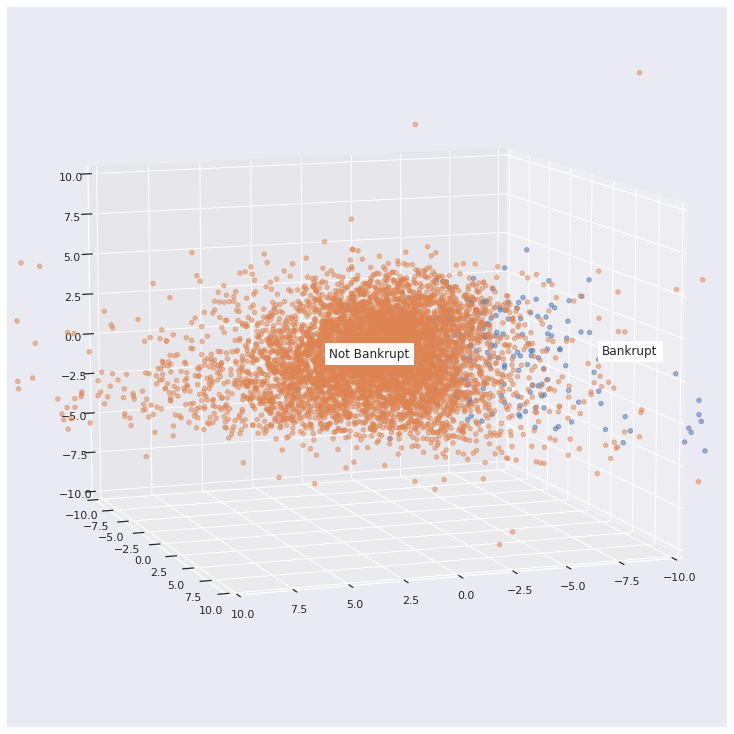

In [131]:
fig = plt.figure(1, figsize=(10, 10))
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=10, azim=70, autoscale_on=True)

ax.scatter(X_PCA[Y_modified == 1, 0], X_PCA[Y_modified == 1, 1], X_PCA[Y_modified == 1, 2],alpha= 0.5)
ax.scatter(X_PCA[Y_modified == 0, 0], X_PCA[Y_modified == 0, 1], X_PCA[Y_modified == 0, 2],alpha= 0.5)

for name, label in [('Bankrupt', 1), ('Not Bankrupt', 0)]:
    ax.text3D(X_PCA[Y_modified == label, 0].mean()*2,
              X_PCA[Y_modified == label, 1].mean()*2,
              X_PCA[Y_modified == label, 2].mean()*2,
               name,
              horizontalalignment='center',
              bbox=dict(alpha=1, edgecolor='w', facecolor='w'))

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)

plt.show()

The first three principal components demonstrate a visible seperation between the two classes.

In [132]:
explained_variance = pca.explained_variance_ratio_
print('Explained variation per principal component: {}'.format(explained_variance))
    

explained_variance = np.insert(explained_variance, 0, 0)
cumulative_variance = np.cumsum(np.round(explained_variance, decimals=4)) 

Explained variation per principal component: [0.16171242 0.07617613 0.05976045 0.04659219 0.03884215 0.03379808
 0.03326355 0.03179611 0.02693613 0.02523953 0.02148075 0.02067581
 0.01813988 0.01712692 0.01639747 0.01593944 0.01381627 0.01348089
 0.01318818 0.01291395 0.01220686 0.01196292 0.01182387 0.01161935
 0.01142334 0.01128966 0.01120246 0.01097305 0.01086461 0.01070811]


In [133]:
pc_df = pd.DataFrame(['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'], columns=['PC'])
explained_variance_df = pd.DataFrame(explained_variance, columns=['Explained Variance'])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=['Cumulative Variance'])


df_explained_variance = pd.concat([pc_df, explained_variance_df[1:11], cumulative_variance_df[1:11]], axis=1)
df_explained_variance

,PC,Explained Variance,Cumulative Variance
0,PC1,NaN,NaN
1,PC2,0.161712,0.1617
2,PC3,0.076176,0.2379
3,PC4,0.059760,0.2977
4,PC5,0.046592,0.3443
5,PC6,0.038842,0.3831
6,PC7,0.033798,0.4169
7,PC8,0.033264,0.4502
8,PC9,0.031796,0.4820
9,PC10,0.026936,0.5089


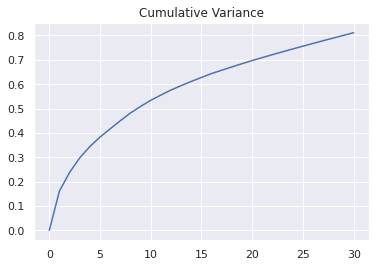

In [134]:
plt.plot(cumulative_variance)
plt.title("Cumulative Variance")
plt.show()

We see that approximately 30 principle components are needed to reach a cumulative explained variance of 80%. 

Now we will compare the spread of the first 4 principle components to the spread of the 4 original highest ranked features according to ANOVA F measure.

In [135]:
Y_cv = df_train['Bankrupt?']
X_cv = df_train.drop('Bankrupt?', axis=1)


In [136]:
#obtaining the 30 best original features by ANOVA F measure for comparison
best_k = SelectKBest(score_func=f_classif , k=30)
best_k.fit(X_cv, Y_cv)
X_k = best_k.transform(X_cv)

mask = best_k.get_support()
new_features = X_cv.columns[mask]
print("10 best original features:\n",new_features[:10])

10 best original features:
 Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %'],
      dtype='object')


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [93] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


The first three features are ROA(C),ROA(A) and ROA(B) and we already know that they are highly correlated. Therefore, we will display the 1st, 4th and 5th features isntead of the first three.

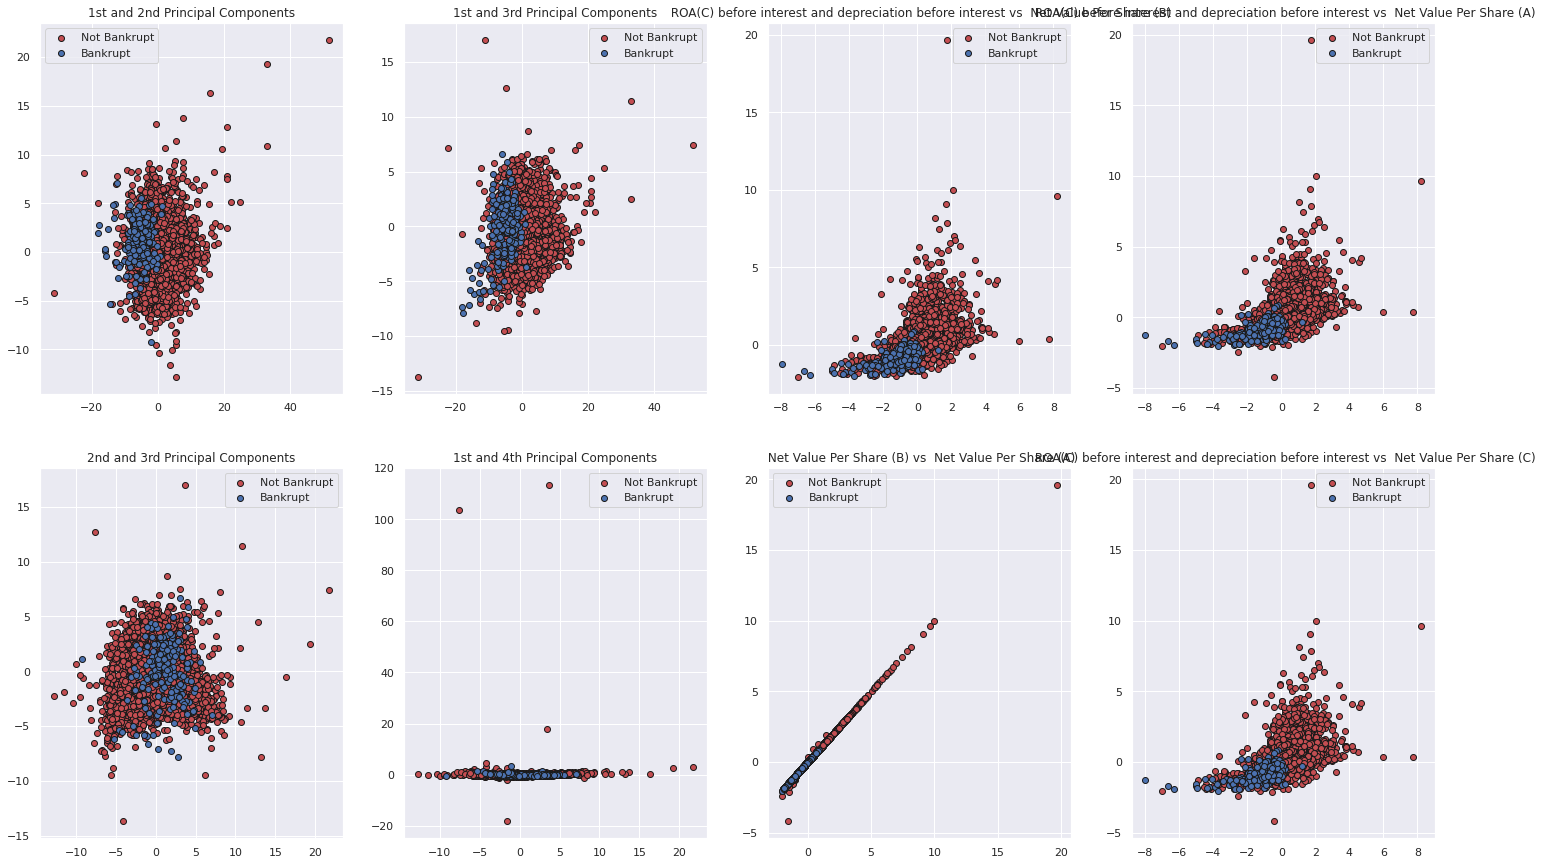

In [137]:
#creating plots
fig, ((ax1, ax2, ax5, ax6), (ax3, ax4, ax7, ax8)) = plt.subplots(2, 4,figsize=(25, 15))

# ------------------------ Principal Components -------------------------------------
ax1.scatter(X_PCA[Y_cv == 0, 0],X_PCA[Y_cv == 0, 1], color='r', label="Not Bankrupt",edgecolor='k')
ax1.scatter(X_PCA[Y_cv == 1,0],X_PCA[Y_cv == 1, 1], color='b', label="Bankrupt",edgecolor='k')
ax1.set_title("1st and 2nd Principal Components")
ax1.legend()

ax2.scatter(X_PCA[Y_cv == 0, 0],X_PCA[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax2.scatter(X_PCA[Y_cv == 1,0],X_PCA[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax2.set_title("1st and 3rd Principal Components")
ax2.legend()

ax3.scatter(X_PCA[Y_cv == 0, 1],X_PCA[Y_cv == 0, 2], color='r', label="Not Bankrupt",edgecolor='k')
ax3.scatter(X_PCA[Y_cv == 1,1],X_PCA[Y_cv == 1, 2], color='b', label="Bankrupt",edgecolor='k')
ax3.set_title("2nd and 3rd Principal Components")
ax3.legend()

ax4.scatter(X_PCA[Y_cv == 0, 1],X_PCA[Y_cv == 0, 3], color='r', label="Not Bankrupt",edgecolor='k')
ax4.scatter(X_PCA[Y_cv == 1,1],X_PCA[Y_cv == 1, 3], color='b', label="Bankrupt",edgecolor='k')
ax4.set_title("1st and 4th Principal Components")
ax4.legend()

# ------------------------ Original Features -------------------------------------
ax5.scatter(X_k[Y_cv == 0, 0],X_k[Y_cv == 0, 3], color='r', label="Not Bankrupt",edgecolor='k')
ax5.scatter(X_k[Y_cv == 1,0],X_k[Y_cv == 1, 3], color='b', label="Bankrupt",edgecolor='k')
ax5.set_title(new_features[0]+" vs "+new_features[3])
ax5.legend()

ax6.scatter(X_k[Y_cv == 0, 0],X_k[Y_cv == 0, 4], color='r', label="Not Bankrupt",edgecolor='k')
ax6.scatter(X_k[Y_cv == 1,0],X_k[Y_cv == 1, 4], color='b', label="Bankrupt",edgecolor='k')
ax6.set_title(new_features[0]+" vs "+new_features[4])
ax6.legend()

ax7.scatter(X_k[Y_cv == 0, 3],X_k[Y_cv == 0, 4], color='r', label="Not Bankrupt",edgecolor='k')
ax7.scatter(X_k[Y_cv == 1,3],X_k[Y_cv == 1, 4], color='b', label="Bankrupt",edgecolor='k')
ax7.set_title(new_features[3]+" vs "+new_features[4])
ax7.legend()

ax8.scatter(X_k[Y_cv == 0, 0],X_k[Y_cv == 0, 5], color='r', label="Not Bankrupt",edgecolor='k')
ax8.scatter(X_k[Y_cv == 1,0],X_k[Y_cv == 1, 5], color='b', label="Bankrupt",edgecolor='k')
ax8.set_title(new_features[0]+" vs "+new_features[5])
ax8.legend()

A visual seperation between the two classes is present for all of the feature pairs above, however, whether the models can succesfully learn decision boundaries that correspond to this seperation is uncertain.

In preivous versions of this notebook, it was observed that using only PCA components did not outperform the original features for most models and when it did, the difference in performance was negligable. Therefore, we will instead add the best 10 principal components to the best 30 original + engineered features to obtain our final training dataset.

In [138]:
bestk_df.columns[0:13]

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Operating profit/Paid-in capital'],
      dtype='object')

In [139]:
#Forming the training set
#getting the best 10 principal components
PC_df = pd.DataFrame(data = X_PCA[:,:10]
             , columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])
#getting the best 30 features
bestk_df = pd.DataFrame(data = X_k, columns = new_features )

X_cv = pd.concat( [bestk_df, PC_df] , axis=1)

#Forming the test set

#getting the best 10 principal components
X_PCA_test = pca.transform(X_test)                   
PC_df_test = pd.DataFrame(data = X_PCA_test[:,:10]
             , columns = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']) 

#getting the best 30 features
X_k_test = best_k.transform(X_test)
bestk_test_df = pd.DataFrame(data = X_k_test, columns = new_features )
          
X_test = pd.concat( [bestk_test_df, PC_df_test] , axis=1)


In [140]:
print("Bankrupt?")
print("No   : " , df_train['Bankrupt?'].value_counts()[0] , " -> ", round( 100*df_train['Bankrupt?'].value_counts()[0]/len(df_train) ),"%" )
print("Yes  : " , df_train['Bankrupt?'].value_counts()[1] , "  -> ", round( 100*df_train['Bankrupt?'].value_counts()[1]/len(df_train) ),"%" )

Bankrupt?
No   :  5934  ->  97 %
Yes  :  188   ->  3 %


#### Balancing the training set

A version of the training data resampled to increase the ratio of "Bankrupt? = 1" labelled data points will evaluated along with the original training set. A combination of over and under-sampling ( SMOTE + Tomek ) will be used.

In [141]:
smt = SMOTE(sampling_strategy=0.3)
X_smt, y_smt = smt.fit_resample(X_cv, Y_cv)

In [142]:
sss = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

## Machine Learning Models

The following methods will be evaluated using,

First simpler models to observe the difficulty of the task:
- Logistic Regression Classifier
- K Nearest Neighbours

As will be seen, performance on these algorithms will not be satisfactory, so they will be followed by more complex models to maximize performance:
- Random Forest
- XGBoost

### Logistic Regression

To search for the best parameter set, F1 score will be used as the evaluation metric. If accuracy is used, simply labelling all data points as not Bankrupt is enough to obtain 96-97% accuracy due to the inbalanced data. F1 score better displays performance, given that the positive class is only 3% of the data.

#### Without Dataset Resampling

In [143]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-8,1,10), "penalty":["none","l1","l2"]}
            
    #logistic regression - Original Features
    log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=5000, random_state = 42)  
    search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',
                                  cv=sss, n_jobs=-1 )
    results = search.fit(X_cv, Y_cv)

    print("Cross Validation Resuts for Logistic Regression without Resampled Data")
    print("Best F1 Score: ",results.best_score_)
    print("Parameters: ", results.best_params_)


Cross Validation Resuts for Logistic Regression without Resampled Data
Best F1 Score:  0.2846068853922248
Parameters:  {'C': 0.01, 'penalty': 'l2'}


Testing the best performer:

In [144]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)


    best_logit = LogisticRegression( C = 0.01, penalty='l2', class_weight ='balanced', solver ='saga', max_iter = 5000, random_state = 42 )
    best_logit.fit(X_cv, Y_cv)

    # Testing 
    y_pred = best_logit.predict(X_test)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.8563049853372434
Precision Score : 0.16071428571428573
Recall Score : 0.8181818181818182
F1 Score : 0.2686567164179105



#### With Dataset Resampling
We will evaluate whether resampling the data to increase the representation of the positive labelled class will improve the testing F1 score.

In [145]:
print("With resampled training data:")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    Log_param_grid = {"C":np.logspace(-8,1,10), "penalty":["none","l1","l2"]}
            
    #logistic regression
    log_model = LogisticRegression(class_weight ='balanced',solver ='saga', max_iter=500,  random_state = 42)  
    search = GridSearchCV(log_model, Log_param_grid, scoring ='f1',cv=sss, n_jobs=-1)
          
    results = search.fit(X_smt, y_smt)
      
    print("Cross Validation Resuts for Logistic Regression with Resampled Data")
    print("Best F1 Score: ",results.best_score_)
    print("Parameters: ", results.best_params_)

With resampled training data:
Cross Validation Resuts for Logistic Regression with Resampled Data
Best F1 Score:  0.7762190413188395
Parameters:  {'C': 1.0, 'penalty': 'l1'}


Now we obtain the test performance (test set was not resampled) with the best parameter configuration:

In [146]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    best_logit = LogisticRegression( C = 1, penalty='l1', class_weight ='balanced', solver ='saga', max_iter = 500,  random_state = 42 )
    best_logit.fit(X_smt, y_smt)

    y_pred = best_logit.predict(X_test)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.8841642228739003
Precision Score : 0.1724137931034483
Recall Score : 0.6818181818181818
F1 Score : 0.27522935779816515


  Both accuracy and F1 score appear to be worse compared to the non-resampled version. Overall, resampling the data does not appear to result in significant improvement in performance.
  
## K Nearest Neighbours Classifier

In [147]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    knn_grid = { 'n_neighbors': [3, 5, 7, 9, 11],'metric':['euclidean','manhattan']  }

    knn_model = KNeighborsClassifier(algorithm='brute')
    search = GridSearchCV(knn_model, knn_grid, scoring='f1', cv=sss, n_jobs=-1)
    results = search.fit(X_cv, Y_cv)

    print("Cross Validation Resuts for KNN with Resampled Data")
    print("Best F1 Score: ",results.best_score_)
    print("Parameters: ", results.best_params_)

Cross Validation Resuts for KNN with Resampled Data
Best F1 Score:  0.3254079317179018
Parameters:  {'metric': 'manhattan', 'n_neighbors': 3}


Now we obtain the test performance with the best parameter configuration:

In [148]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    knn_model = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric='manhattan' )
    knn_model.fit(X_cv, Y_cv)

    #testing
    y_pred = knn_model.predict(X_test)

    # Model Evaluation metrics 

    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

Accuracy Score : 0.9560117302052786
Precision Score : 0.21428571428571427
Recall Score : 0.13636363636363635
F1 Score : 0.16666666666666663


It appears that performance (F1 Score) on the cross validation set does not translate well to the test set. Also, F1 score is lower than it was for all variations of logistic regression.

### Random Forest Classifier

In [149]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    tree_param = {'criterion':['gini','entropy'],'max_depth':[5,7,10,12,15,20,30,40,50]}

    search = GridSearchCV(RandomForestClassifier( random_state = 42),tree_param , scoring ='f1',cv=sss, n_jobs=-1 )
    results = search.fit(X_smt, y_smt)

    print("Cross Validation Resuts for Random Forest with Resampled Data")
    print("Best F1 Score: ",results.best_score_)
    print("Parameters: ", results.best_params_)

Cross Validation Resuts for Random Forest with Resampled Data
Best F1 Score:  0.9235907984525147
Parameters:  {'criterion': 'entropy', 'max_depth': 15}


In [150]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    forest = RandomForestClassifier(criterion="entropy", max_depth= 20, random_state = 42 )
    forest.fit(X_smt, y_smt)

    # Testing 
    y_pred =  forest.predict(X_test)

    # Model Evaluation metrics 
    print('Accuracy Score : ' + str(accuracy_score(Y_test,y_pred)))
    print('Precision Score : ' + str(precision_score(Y_test,y_pred)))
    print('Recall Score : ' + str(recall_score(Y_test,y_pred)))
    print('F1 Score : ' + str(f1_score(Y_test,y_pred)))

    print(classification_report(Y_test,y_pred))

Accuracy Score : 0.9589442815249267
Precision Score : 0.36363636363636365
Recall Score : 0.36363636363636365
F1 Score : 0.36363636363636365
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       660
           1       0.36      0.36      0.36        22

    accuracy                           0.96       682
   macro avg       0.67      0.67      0.67       682
weighted avg       0.96      0.96      0.96       682



### XGBoost Classifier

--- incomplete ---- 

In [151]:
dtrain_origin = xgb.DMatrix(X_cv, label=Y_cv)
dtrain_smt = xgb.DMatrix(X_smt, label=y_smt)
    
dtest = xgb.DMatrix(X_test, label=Y_test)

In [152]:
# TO DO : Implement parameter tuning my random search

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning) #ignore constant feature
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    params = {"objective":'reg:logistic','learning_rate': 0.05,
                'max_depth': 10, 'booster': 'gbtree' }
    
    #For the non-resmapled taining data
    cv_origin_results = xgb.cv(dtrain=dtrain_origin, params=params, nfold=10,
                    num_boost_round=60,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=42)
    
    # Print cv_results
    mean_AUC = cv_origin_results['test-auc-mean'].max()
    boost_rounds = cv_origin_results['test-auc-mean'].idxmax()
    print("\t For the non-resmapled data: AUC {} for {} rounds".format(mean_AUC, boost_rounds))
    
    #For the training data with resampling
    cv_smt_results = xgb.cv(dtrain=dtrain_smt, params=params, nfold=10,
                    num_boost_round=60,early_stopping_rounds=10,metrics="auc", as_pandas=True, seed=42)
    # Print cv_results
    mean_AUC = cv_smt_results['test-auc-mean'].max()
    boost_rounds = cv_smt_results['test-auc-mean'].idxmax()
    print("\t For the resmapled data: AUC {} for {} rounds".format(mean_AUC, boost_rounds))
    

	 For the non-resmapled data: AUC 0.9165459 for 59 rounds
	 For the resmapled data: AUC 0.9901909 for 59 rounds


### TO DO: Complete XGBoost

## Coparison of Models

In [153]:
# TO DO 



---


## **Ideas**


*   Try feature selection methods that account for redundancy (ex: MRMR)
*   Do research on the financial indicators and try to engineer financially logical features from the existing set.
